In [28]:
import os
import numpy as np
import pandas as pd
import skimage.io as skio
import skimage.transform as skit

import p2pspatial

%matplotlib inline
import matplotlib.pyplot as plt

In [110]:
rootfolder = os.path.join(os.environ['SECOND_SIGHT_DATA'], 'shape')
X, y = p2pspatial.load_data(rootfolder, subject='12-005', electrodes=['C04'], amplitude=2.0)
X.shape

(5, 10)

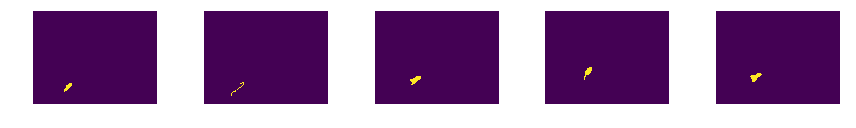

In [112]:
ncols = np.minimum(5, len(X))
nrows = int(np.ceil(len(X) / ncols))
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, nrows * 3))
for ax, Xrow in zip(axes.ravel(), X.iterrows()):
    _, row = Xrow
    ax.imshow(skio.imread(os.path.join(row['folder'], row['filename'])))
    ax.axis('image')
    ax.axis('off')
fig.tight_layout()

In [166]:
def center_phosphene(img_in):
    m = skim.moments(img_in, order=1)
    transl = (img_in.shape[1] // 2 - m[1, 0] / m[0, 0],
              img_in.shape[0] // 2 - m[0, 1] / m[0, 0])
    img_out = skit.warp(img_in, skit.SimilarityTransform(translation=transl).inverse)
    return img_out

In [ ]:
shift_y, shift_x = np.array(image.shape[:2]) / 2.
tf_rotate = transform.SimilarityTransform(rotation=np.deg2rad(30))
tf_shift = transform.SimilarityTransform(translation=[-shift_x, -shift_y])
tf_shift_inv = transform.SimilarityTransform(translation=[shift_x, shift_y])
image_rotated = transform.warp(image, (tf_shift + (tf_rotate + tf_shift_inv)).inverse)

In [374]:
def center_scale_phosphene(img_truth, img_pred):
    assert np.allclose(img_truth.shape, img_pred.shape)
    img_truth = center_phosphene(img_truth)
    img_pred = center_phosphene(img_pred)
    
    area_truth = skim.moments(img_truth, order=0)[0, 0]
    area_pred = skim.moments(img_pred, order=0)[0, 0]
    scale = area_truth / area_pred

    shift_y, shift_x = np.array(img_pred.shape[:2]) / 2.0
    tf_shift = skit.SimilarityTransform(translation=[-shift_x, -shift_y])
    tf_scale = skit.SimilarityTransform(scale=scale)
    tf_shift_inv = skit.SimilarityTransform(translation=[shift_x, shift_y])
    
    img_out = skit.warp(img_pred, (tf_shift + (tf_scale + tf_shift_inv)).inverse)
    return img_out

In [368]:
def dice_coeff(img0, img1):
    img0 = img0 > 0
    img1 = img1 > 0
    return 2 * np.sum(img0 * img1) / (np.sum(img0) + np.sum(img1))

In [375]:
img0 = skio.imread(os.path.join(X.loc[0, 'folder'], X.loc[0, 'filename']))
img1 = skio.imread(os.path.join(X.loc[4, 'folder'], X.loc[4, 'filename']))

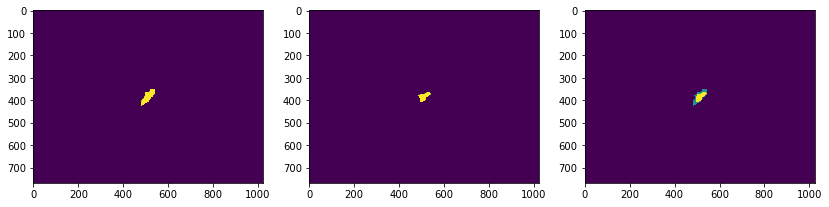

In [376]:
img_true = center_phosphene(img0)
img_pred = center_scale_phosphene(img0, img1)
plt.figure(figsize=(14, 6))
plt.subplot(131)
plt.imshow(img_true)
plt.subplot(132)
plt.imshow(img_pred)
plt.subplot(133)
plt.imshow(img_true + img_pred)

(0.062831853071795951, 0.70066292707802147)

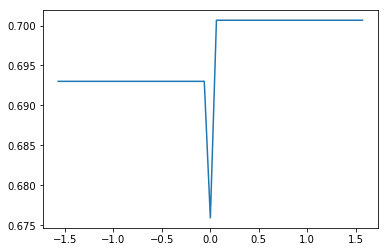

In [377]:
rot = np.linspace(-np.pi / 2, np.pi / 2, 51)
dice = [dice_coeff(img_true, skit.rotate(img_pred, r)) for r in rot]
plt.plot(rot, dice)
rot[np.argmax(dice)], np.max(dice)

In [378]:
np.abs(rot[np.isclose(dice, np.max(dice))]).min()

0.062831853071795951

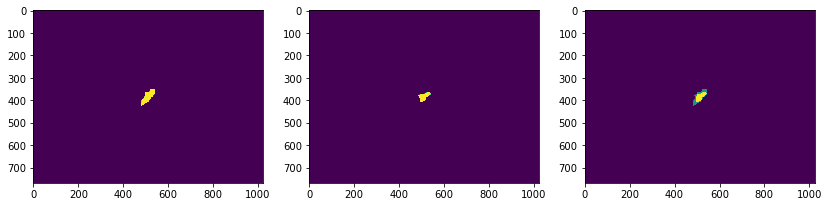

In [379]:
plt.figure(figsize=(14, 6))
plt.subplot(131)
plt.imshow(img_true)
plt.subplot(132)
plt.imshow(skit.rotate(img_pred, rot[np.argmax(dice)]))
plt.subplot(133)
plt.imshow(img_true + skit.rotate(img_pred, rot[np.argmax(dice)]))